# 卷积代码具体实现

误区澄清：输出的大小不一定等于输入图像的大小，这取决于使用的卷积方式（padding、stride）。

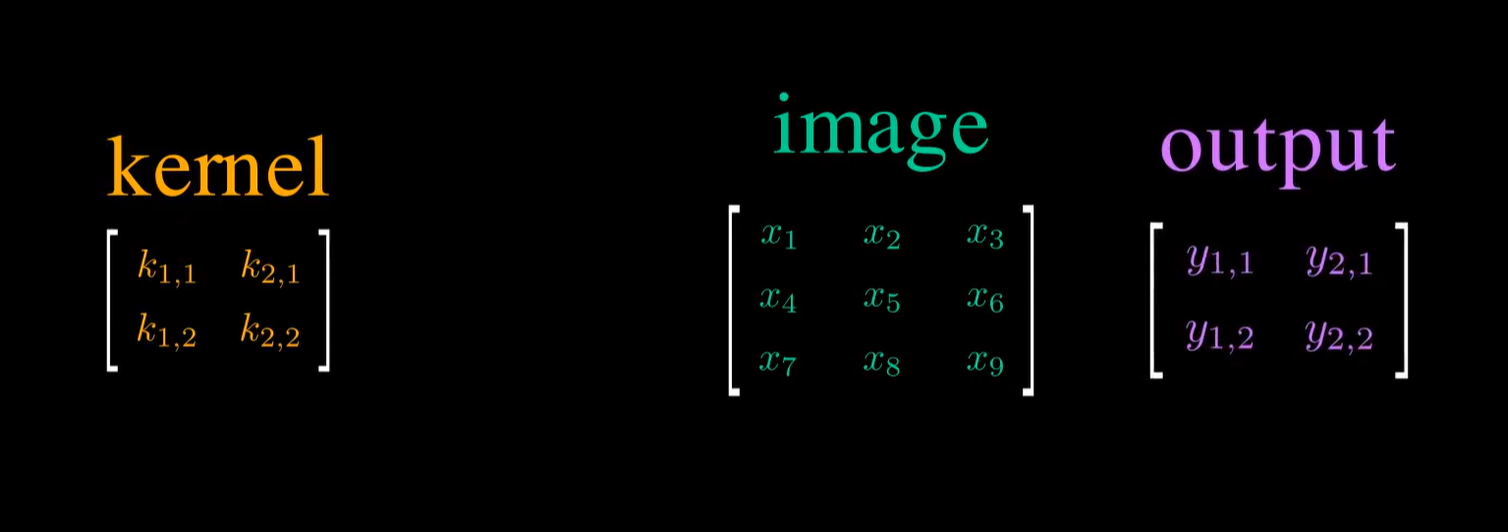

对于二维卷积，输出尺寸为：
$$
output\_size = \frac{input\_size-kernel\_size}{stride}+1
$$
一般而言stride=1,即每次移动一个像素

若想让输出和原图尺寸一样，需要添加 padding,且保证 padding = (kernel_size - 1) / 2

如果 kernel 是 3×3，则 padding = 1 → 输出尺寸不变  
如果 kernel 是 2×2，则 padding = 0.5 → 不行（必须整数）  
所以：只有当 kernel 是奇数时，才能通过 padding 让输出和输入一样大

## Padding函数

### zero-padding
在图像边缘补零（zero-padding），使得卷积核可以在边缘也能完整地覆盖。

In [2]:
import numpy as np
def padding(img, padding_size, type):
    """
        The function you need to implement for Q1 a).
        Inputs:
            img: array(float)
            padding_size: int
            type: str, zeroPadding/replicatePadding
        Outputs:
            padding_img: array(float)
    """
    height,width=img.shape

    padding_height=height+2*padding_size
    padding_width=width+2*padding_size

    if type=="zeroPadding":
        padding_img=np.zeros((padding_height,padding_width))
        padding_img[padding_size:-padding_size,padding_size:-padding_size]=img  
        return padding_img
    elif type=="replicatePadding":
        padding_img=np.empty((padding_height,padding_width))
        padding_img[padding_size:-padding_size,padding_size:-padding_size]=img

        # 填充上下行
        padding_img[0:padding_size,padding_size:-padding_size]=img[0,:] # 0:padding_size而不是0
        padding_img[-padding_size:,padding_size:-padding_size]=img[-1,:]

        # 填充左右行+角
        padding_img[:,0:padding_size]=padding_img[:,padding_size:padding_size+1]
        padding_img[:, -padding_size:]=padding_img[:, -padding_size-1:-padding_size]
        return padding_img

original_image = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])
padded_zero_image = padding(original_image, 1, "zeroPadding")
print("\nZero Padded Image (padding_size=1):\n", padded_zero_image)
padded_replicate_image = padding(original_image, 1, "replicatePadding")
print("\nReplicate Padded Image (padding_size=1):\n", padded_replicate_image)


Zero Padded Image (padding_size=1):
 [[0. 0. 0. 0. 0.]
 [0. 1. 2. 3. 0.]
 [0. 4. 5. 6. 0.]
 [0. 7. 8. 9. 0.]
 [0. 0. 0. 0. 0.]]

Replicate Padded Image (padding_size=1):
 [[1. 1. 2. 3. 3.]
 [1. 1. 2. 3. 3.]
 [4. 4. 5. 6. 6.]
 [7. 7. 8. 9. 9.]
 [7. 7. 8. 9. 9.]]


## Convolution via Toeplitz Matrix
这个每条对角线上的元素都相同的矩阵，就叫做 **托普利茨矩阵 (Toeplitz Matrix)**。我们成功地把一个“滑动”的运算，变成了一个固定的巨大矩阵。

一维情况：
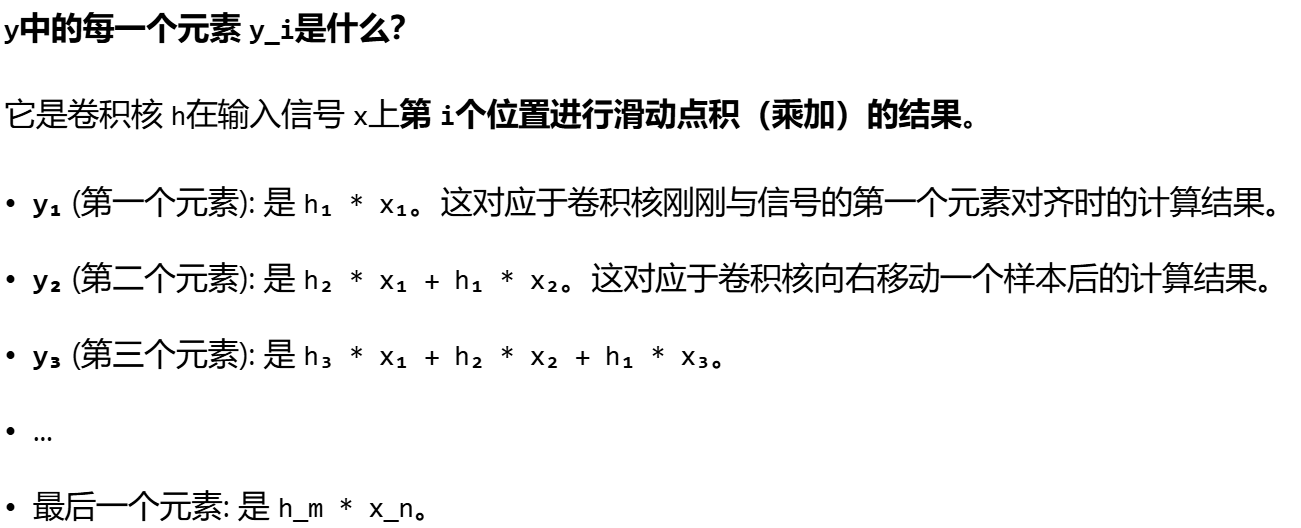
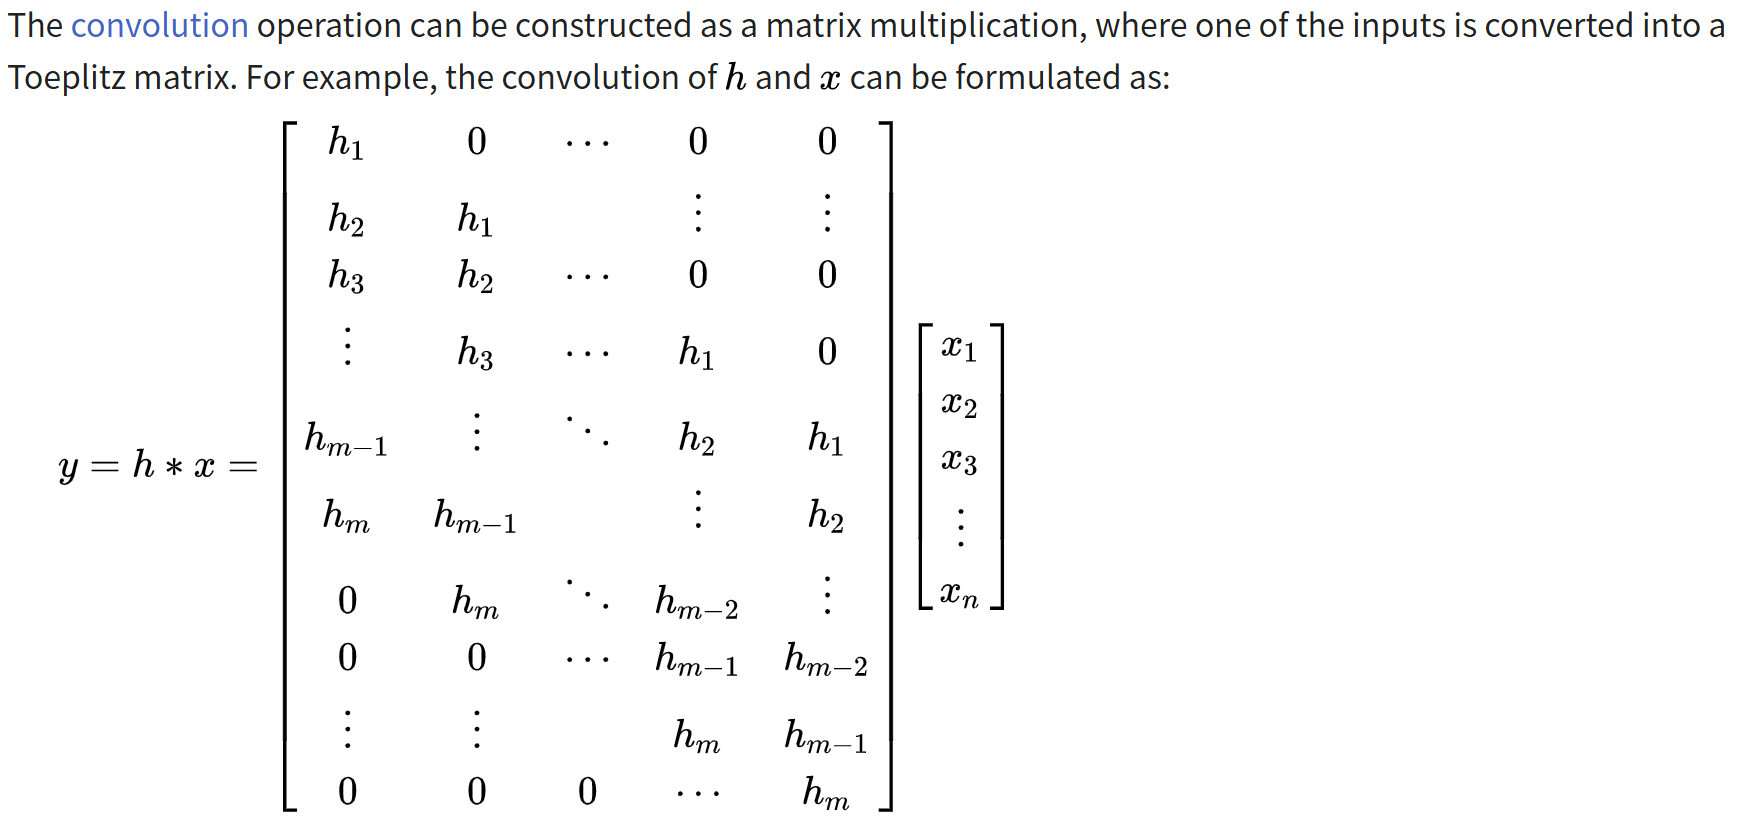

二维情况：
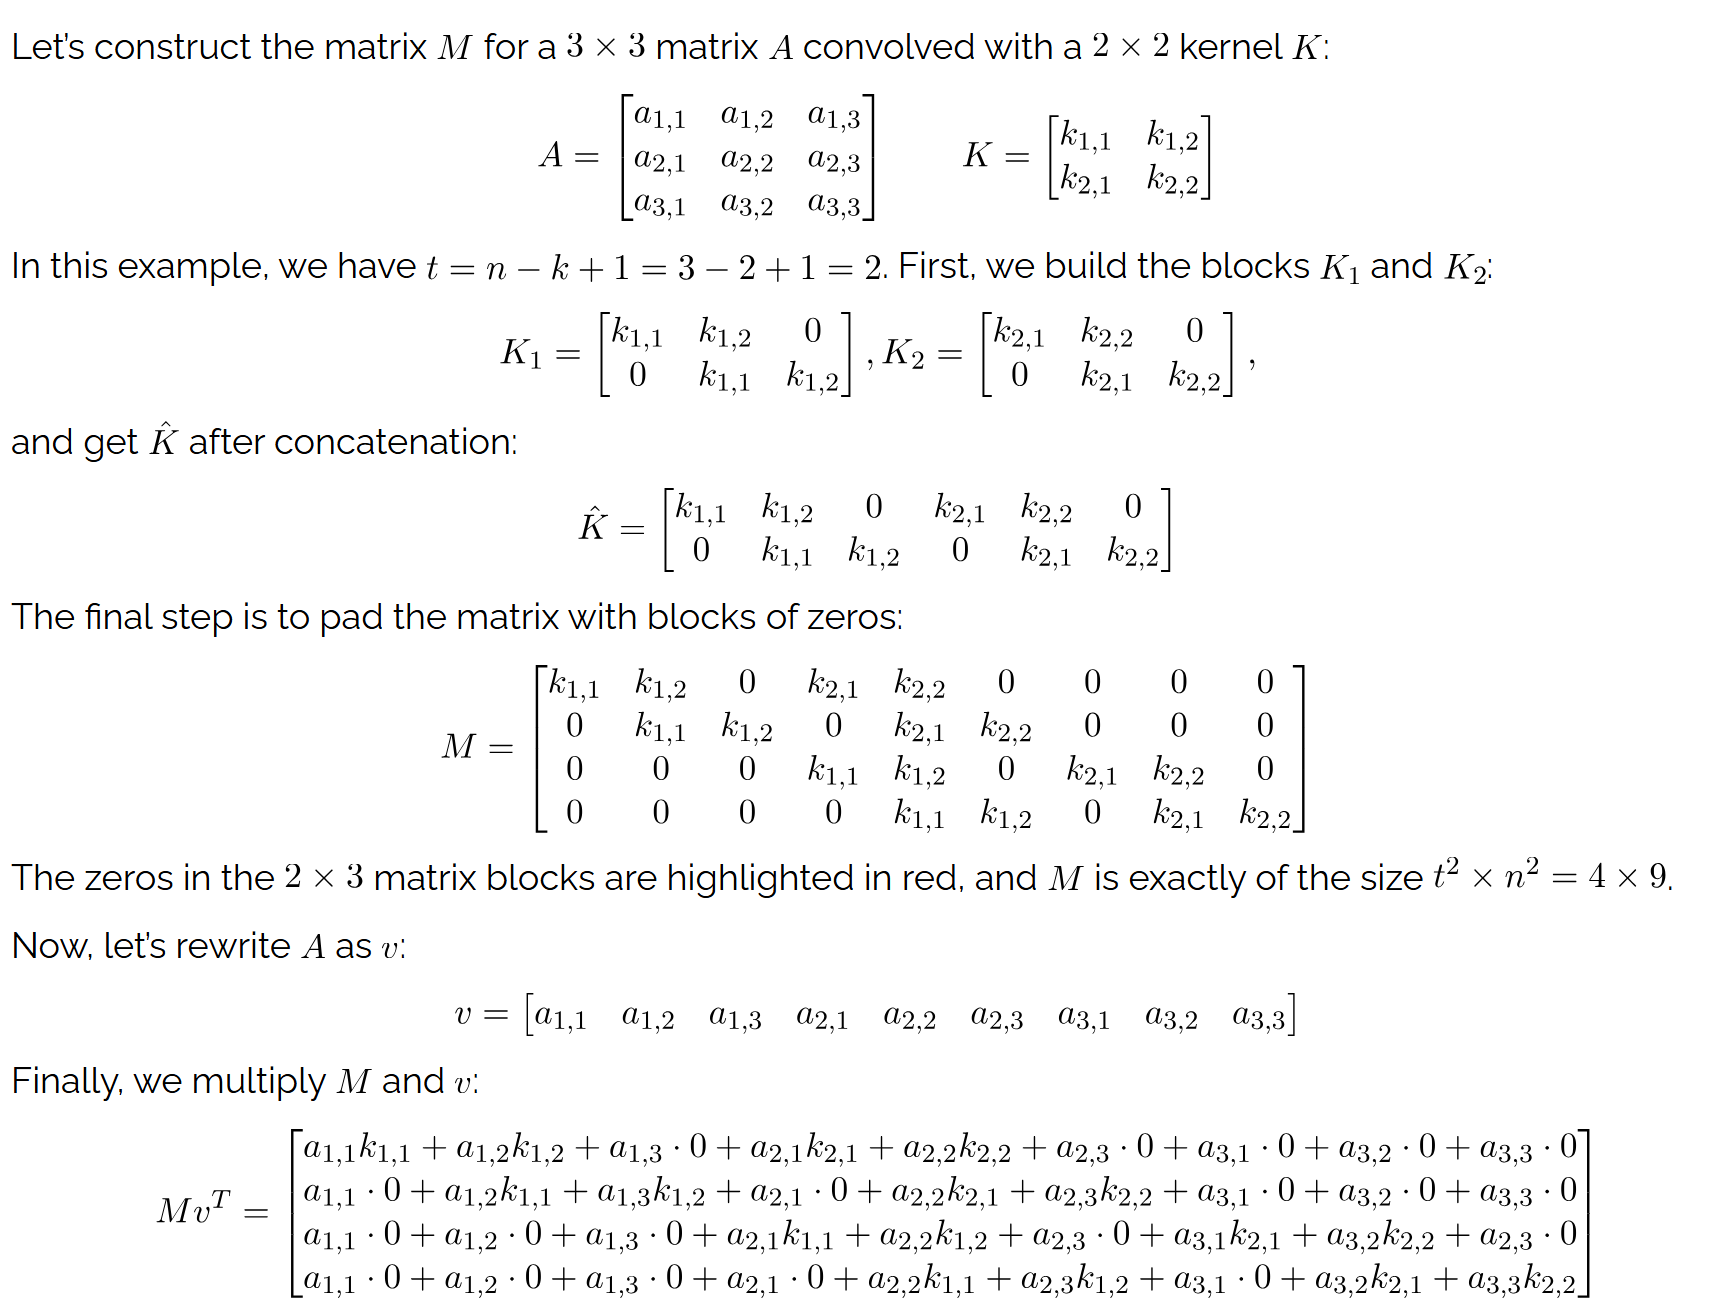

操作流程：
1.  **压平（矢量化）图像**: 把一个 `6x6` 的图像，按行（或按列）展开，变成一个 `36x1` 的长向量。
    `img_vector = [pixel(0,0), pixel(0,1), ..., pixel(0,5), pixel(1,0), ... pixel(5,5)]`

2.  **压平（矢量化）卷积核**: 同样，把 `3x3` 的卷积核压平成 `9x1` 的向量。

3.  **构建巨大的托普利茨矩阵**: 这是最难想象的一步。这个巨大的矩阵的**每一行**，都代表了卷积核在原图上**某一个特定位置**的运算。

### 构建Toeplitz Matrix
以一个 6x6 的图像，和一个 3x3 的卷积核为例  
1. 让我们来构建第一行，也就是计算 o(0,0) 的那一行。

问: 为了计算输出图像的第一个像素 o(0,0)，我们的 3x3 卷积核应该放在 8x8 填充后图像的哪个位置？  
答: 放在左上角。 

问: 这个 3x3 的区域覆盖了 8x8 填充后图像的哪些像素？  
答: p(0,0), p(0,1), p(0,2)  
p(1,0), p(1,1), p(1,2)  
p(2,0), p(2,1), p(2,2)

问: 这些像素在被压平的 64x1 输入向量中，是第几个元素（索引）？  
索引 = 行号 * 填充后宽度 + 列号  
p(0,0) -> 0*8 + 0 = 索引 0  
p(0,1) -> 0*8 + 1 = 索引 1  
p(0,2) -> 0*8 + 2 = 索引 2  
p(1,0) -> 1*8 + 0 = 索引 8  
p(1,1) -> 1*8 + 1 = 索引 9  
p(1,2) -> 1*8 + 2 = 索引 10  
p(2,0) -> 2*8 + 0 = 索引 16  
p(2,1) -> 2*8 + 1 = 索引 17  
p(2,2) -> 2*8 + 2 = 索引 18  
构建: 现在我们来构建Toeplitz矩阵的第一行。这一行有64个元素，它将与 64x1 的输入向量做点积。
我们把压平的 3x3 卷积核 [k0, k1, ..., k8] 的值，放到上面计算出的9个索引位置。
其他 55 个位置全部填 0！  
所以，第一行看起来像这样 (假设 k_flat 是压平的卷积核):  
Row 0 = [k0, k1, k2, 0, 0, 0, 0, 0, k3, k4, k5, 0, ..., 0, k6, k7, k8, 0, ..., 0]

2. 现在我们来构建第二行，它用来计算 o(0,1)
 
问: 为了计算 o(0,1)，卷积核在 8x8 图像上向右滑动了一格。它现在覆盖了哪些像素？这些像素在 64x1 向量中的索引是什么？  
答: 1, 2, 3, 9, 10, 11, 17, 18, 19。所有索引都比第一行对应的索引加了1！  
所以，第二行就是把第一行的非零元素块整体向右平移一格！  
Row 1 = [0, k0, k1, k2, 0, 0, 0, 0, 0, k3, k4, k5, 0, ..., 0, 0, k6, k7, k8, 0, ...]


#### 索引值的数学表达
我们来把这个过程从直观理解升华为一个普适的数学公式。

1. 定义所有变量  
首先，我们必须清晰地定义所有涉及的尺寸： 
- 原图尺寸: H × W (在作业中是 6 × 6)
- 卷积核尺寸: kH × kW (在作业中是 3 × 3)
- 填充尺寸: P (为了保持输出尺寸不变，P = floor(kH / 2)，在作业中是 1)
- 填充后图像尺寸: Hp × Wp
    - Hp = H + 2*P (在作业中是 6 + 2*1 = 8)
    - Wp = W + 2*P (在作业中是 6 + 2*1 = 8)
- 输出图像尺寸: Ho × Wo (在作业中是 6 × 6)

2. 核心公式  
我们的目标是：当我们在计算输出图像的 (r, c) 位置的像素值时 (Output(r, c))，卷积核内部的 (i, j) 位置的元素 (Kernel(i, j)) 对应的是压平后的填充图像向量中的哪个索引？  
这个索引 Index 的通用数学公式是： 

    Index(r, c, i, j) = (r + i) * Wp + (c + j)  

    其中：  
    (r, c): 你正在计算的输出像素的坐标 (0 <= r < Ho, 0 <= c < Wo)。  
    (i, j): 卷积核内部的相对坐标 (0 <= i < kH, 0 <= j < kW)。  
    Wp: 填充后图像的宽度。 

3. 证明

- 定位卷积核：为了计算输出像素 Output(r, c)，我们需要将 kH x kW 的卷积核覆盖在 Hp x Wp 的填充图像上。卷积的定义决定了卷积核的左上角会精确地放在填充图像的 (r, c) 位置。
- 定位核内元素：现在，我们关注卷积核内部的某个元素，它的相对坐标是 (i, j)。既然核的左上角在 (r, c)，那么这个核内元素在填充图像上的绝对坐标就是 (r + i, c + j)。
- 压平坐标：我们最后需要的是这个绝对坐标在一维向量中的索引。对于一个宽度为 Wp 的二维矩阵，将二维坐标 (y, x) 转换为一维索引的公式是 index = y * Wp + x。
- 代入：我们将第2步得到的绝对坐标 y = (r + i) 和 x = (c + j) 代入第3步的压平公式，就得到了最终的核心公式：Index = (r + i) * Wp + (c + j)

4. 总结
要构建整个36x64的Toeplitz矩阵，你的程序需要：  
- 创建一个 36x64 的全零矩阵 T。
- 压平你的 3x3 卷积核，得到一个 9x1 的向量 k_flat。
- 遍历所有输出像素坐标 (r, c) (从 (0,0) 到 (5,5))。
- 对于每一个 (r, c)，计算它对应的Toeplitz矩阵的行号 row_index = r * Wo + c。
-  在 (r, c) 的循环内部，再遍历卷积核的内部坐标 (i, j) (从 (0,0) 到 (2,2))。
- 对于每一个 (i, j)，使用核心公式 col_index = (r + i) * Wp + (c + j) 计算出它在Toeplitz矩阵中的列号。
- 同时，计算出 (i, j) 在压平的卷积核 k_flat 中的索引 k_index = i * kW + j。
- 执行赋值：T[row_index, col_index] = k_flat[k_index]。
